# Détection de faux Billets 


## Initialisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
from datetime import date 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms


warnings.filterwarnings('ignore')

In [2]:
# fonctions pour l'ACP
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[0, i],  
                pca.components_[1, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[0, i] + 0.05,
                pca.components_[1, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)



def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en un df
    X_ = pd.DataFrame(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # On définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On rajoute la color, les clusters et les labels à X_
    X_["clusters"] =  clusters if clusters is not None else "None" 
    X_["labels"] =  labels if labels is not None else "None"
    c_unique_list = X_["clusters"].sort_values().unique()
    c_dict = {j:i+1 for i, j in enumerate(c_unique_list)}
    X_["colors"] = X_["clusters"].apply(lambda i : c_dict[i])

    # Pour chaque couleur / cluster
    for c in sorted(X_.clusters.unique()) : 
        # On selectionne le sous DF
        sub_X =X_.loc[X_.clusters == c, : ]

        # Clusters and color
        cluster = sub_X.clusters.iloc[0]
        color = sub_X.colors.iloc[0]

        # On affiche les points
        ax.scatter(    sub_X.iloc[:, x], 
                        sub_X.iloc[:, y], 
                        alpha=alpha, 
                        label = cluster ,
                        cmap="Set1", 
                        marker=marker)
        
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_.iloc[:, x]).max() *1.1
    y_max = np.abs(X_.iloc[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if labels : 
        
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y, labels[i], fontsize='14', ha='center',va='center') 

    # Titre, legend et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    if clusters is not None: 
        plt.legend()
    plt.show()

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### Import des données 

In [3]:
df_global = pd.read_csv("Billets.csv")
df_global

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


### Exploration des données

In [4]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
df_global.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### Exploration des groupes de vrai et de faux billets

In [6]:
df_global[df_global['is_genuine']==True].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [7]:
df_global[df_global['is_genuine']==False].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [8]:
df_global.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

# Estimation des valeurs manquantes 

### Extraction des données incompletes 

In [9]:
df_global_manquant = df_global[df_global['margin_low'].isnull()]
df_global_manquant

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [10]:
df_global_complet = df_global[df_global['margin_low'].notnull()]
df_global_complet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [11]:
df_global_complet.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

### On veut créer un modèle qui estime "Margin_Low" en fct des autres valeurs

In [12]:
X = df_global_complet[['diagonal', 'height_left', 'height_right','margin_up', 'length']]
X

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [13]:
y = df_global_complet['margin_low']
y

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Cette fonction sépare nos datas en 1 train set et 1 test set 

### Dimension des sets 

In [15]:
X_train.shape

(1097, 5)

In [16]:
X_test.shape

(366, 5)

In [17]:
y_train.shape

(1097,)

In [18]:
y_test.shape

(366,)

# Création et entrainement de la regression linéaire

In [19]:
regr = LinearRegression() # instanciation
  
regr.fit(X_train, y_train) #Entrainement


LinearRegression()

In [20]:
# Evaluation du modèle
print(regr.score(X, y)) #Score, tester le modèle

0.47637691816198957


In [21]:
# Etude des residus
prediction = regr.predict(X)
residual = (y - prediction)

<AxesSubplot:>

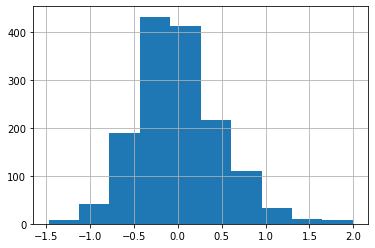

In [22]:
residual.hist()

In [23]:
#appliquer le test de shapiro pour confirmer la normalité des residus
from scipy.stats import shapiro
x, pval = shapiro(residual)
print(pval)

1.195595358827184e-11


La p- Value est inférieure à 0.05


On rejette donc l'hypothèse nulle H0

In [24]:
# On peut rajouter un test de variance pour voir si les variables independantes sont signifiantes
# pour expliquer la variable dependante
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          2.60e-202
Time:                        21:40:49   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

coefficient de détermination R² est à 0.47 

On obtient un ceofficient de Durbin-Watson à 1.893, ce qui est proche de 2, indiquant zéro autocorrélation

### Breusch-Pagan

In [25]:
#perform Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(est2.resid, est2.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 80.16261280174537),
 ('p-value', 7.75953521621434e-16),
 ('f-value', 16.89235884615231),
 ('f p-value', 2.922749656629398e-16)]

null hypothesis (H0): Homoscedasticity is present.

La P-Value est inferieur à 0.05, On rejette donc l'hypothèse nulle H0 


Il y a donc absences d'homoscédasticité

# On utilise notre modèle pour determiner les valeurs manquantes

In [26]:
y_pred = regr.predict(X_test)
y_pred


array([3.89141618, 5.02609402, 3.97731934, 3.98849918, 4.14718356,
       4.00143138, 4.69574163, 4.90401818, 3.82574816, 4.25879709,
       4.07786336, 4.74780105, 4.99680996, 5.54955207, 4.15446664,
       4.21059932, 4.13670561, 4.32561678, 4.7346256 , 4.26953556,
       4.2222328 , 5.31089983, 4.94088127, 4.42664947, 4.73479218,
       4.4540928 , 4.12266406, 5.32469015, 4.12654219, 5.09354796,
       5.0055617 , 4.795065  , 4.65412194, 4.22906486, 4.34560158,
       4.04404191, 4.20374103, 5.16076792, 4.24548345, 4.6117096 ,
       4.92793286, 3.91985379, 4.87775511, 4.33518455, 4.12687321,
       4.10041343, 4.89921732, 4.2578174 , 5.17964113, 4.94615112,
       4.04221548, 4.35345243, 4.22640088, 5.10671957, 4.58446938,
       4.46242736, 5.07441464, 4.24345434, 4.04973115, 5.06004195,
       4.29710322, 5.04647117, 5.08288219, 4.20834337, 4.71189122,
       4.9134073 , 4.26989535, 4.3573273 , 4.26209272, 4.13986638,
       4.12053975, 4.52486014, 4.18619479, 3.97366772, 4.15152

In [27]:
y_test

555     4.47
1345    6.16
768     4.04
299     4.24
886     3.73
        ... 
377     3.67
238     3.74
737     3.77
60      3.71
1349    5.77
Name: margin_low, Length: 366, dtype: float64

In [28]:
df_global_manquant['margin_low'] = regr.predict(df_global_manquant[['diagonal', 'height_left', 'height_right','margin_up', 'length']])

### On a ici les estimations pour compléter les valeurs manquantes 

In [29]:
df_global_Full = pd.concat([df_global_complet, df_global_manquant])
df_global_Full 

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.012429,2.93,111.21
1315,False,172.08,104.15,104.17,4.770806,3.40,112.29
1347,False,171.72,104.46,104.12,5.676590,3.61,110.31
1435,False,172.66,104.33,104.41,5.184526,3.56,111.47


# 

# Classification Authenticité des billets

In [30]:
#on va d'utiliser la fonction robust scaler pour normaliser les données  qui en theorie gere mieux les outliers
X_proj = df_global_Full[['diagonal', 'height_left', 'height_right','margin_up','margin_low', 'length']]
X = X_proj.values
transformer = RobustScaler().fit(X)
X_scaled = transformer.transform(X)
#df_test["Pred_Reg_Log"] =
X_scaled 

array([[-0.35714286,  2.        ,  2.34090909, -0.78125   ,  0.24705882,
        -0.09923664],
       [-1.19047619, -1.65853659, -0.59090909, -0.46875   , -0.63529412,
         0.09923664],
       [ 1.73809524,  1.07317073, -0.95454545, -0.625     ,  0.10588235,
         0.15267176],
       ...,
       [-0.57142857,  1.02439024,  0.45454545,  1.46875   ,  1.6077531 ,
        -2.02290076],
       [ 1.66666667,  0.70731707,  1.11363636,  1.3125    ,  1.02885397,
        -1.13740458],
       [-0.14285714,  0.58536585,  0.84090909,  0.3125    ,  0.94132619,
        -1.1221374 ]])

In [31]:
# Appliquer l'ACP


#on instancie le pca
pca = PCA()

#on applique le pca sur nos données 
pca.fit(X_scaled)

PCA()

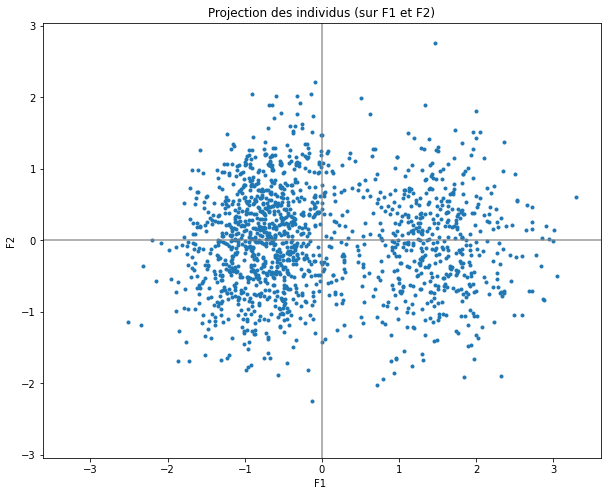

In [32]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)
X_proj = X_proj[:,:2]
display_factorial_planes(X_proj, x_y)

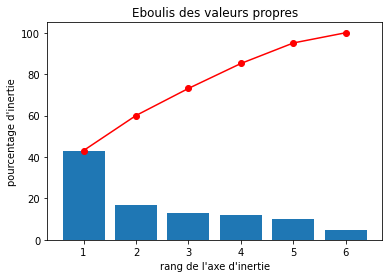

In [33]:
# Eboulis des valeurs propres
display_scree_plot(pca)

plt.show()

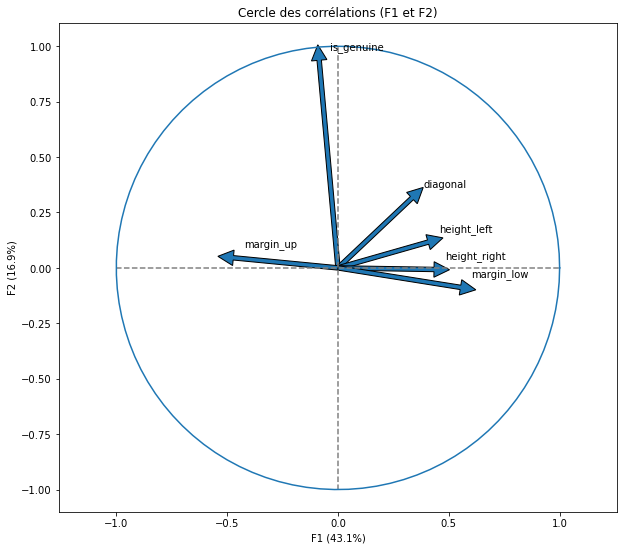

In [34]:
x_y=[0,1]
features=df_global.columns
correlation_graph(pca, x_y,features)

### VIF

In [35]:
# the independent variables set
X = df_global_Full[['diagonal', 'height_left', 'height_right','margin_up','margin_low', 'length']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature            VIF
0      diagonal  169578.726969
1   height_left  115398.377062
2  height_right  104433.896701
3     margin_up     263.804874
4    margin_low      91.114406
5        length   31376.000601


On peut voir ici que les variables Diagonal, Height_Left et Heigh_Right sont fortement corrélées entre elles 

## K-Means

In [36]:
# On utilisera donc toutes nos information afin de detecter "Is_Genuine" via un modèle.

X_proj = df_global_Full[['diagonal', 'height_left', 'height_right','margin_up','margin_low', 'length']]

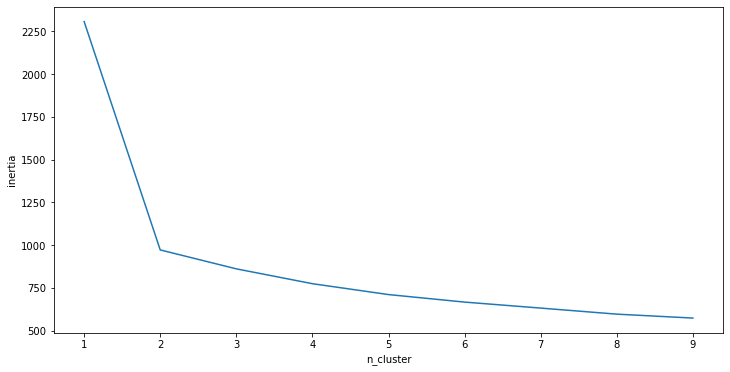

In [37]:
# Utiliser la méthode du coude pour determiner le nombre des clusters
inertia = []
k_list = range(1, 10)
list(k_list)
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_proj) 
  inertia.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, inertia)

In [38]:
# D'apres la courbe, on peut avoir 2 clusters 
# On entraine donc un modèle K-means à 2 clusters

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_proj)

KMeans(n_clusters=2)

In [39]:
# On Injecte le cluster associé au K-means

df_global_Full['Cluster']=kmeans.labels_
df_global_Full

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster
0,True,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,True,171.46,103.36,103.66,3.770000,2.99,113.09,1
2,True,172.69,104.48,103.50,4.400000,2.94,113.16,1
3,True,171.36,103.91,103.94,3.620000,3.01,113.51,1
4,True,171.73,104.28,103.46,4.040000,3.48,112.54,1
...,...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.012429,2.93,111.21,0
1315,False,172.08,104.15,104.17,4.770806,3.40,112.29,0
1347,False,171.72,104.46,104.12,5.676590,3.61,110.31,0
1435,False,172.66,104.33,104.41,5.184526,3.56,111.47,0


In [40]:
# On peut donc comparer les performances de notre modèle

matrix = confusion_matrix(y_true=df_global_Full['is_genuine'], y_pred=df_global_Full['Cluster'])
matrix

array([[481,  19],
       [  2, 998]], dtype=int64)

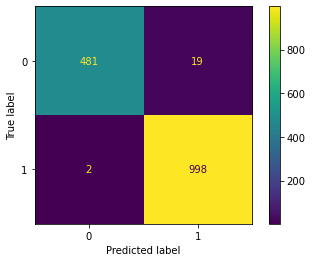

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

plt.show()

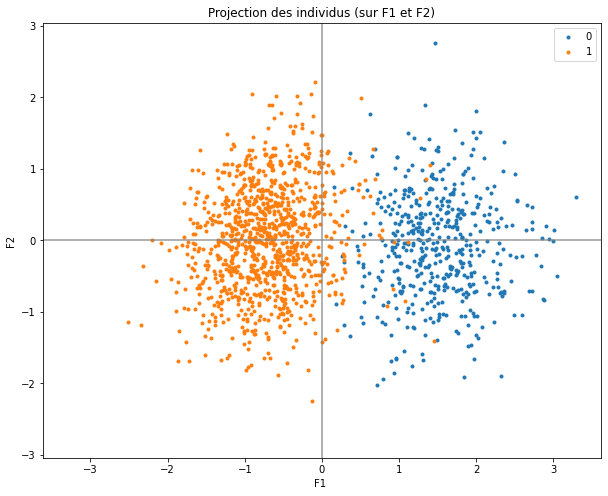

In [42]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)
X_proj = X_proj[:,:2]
display_factorial_planes(X_proj, x_y,clusters = kmeans.labels_ )

# Logistic Regression

In [43]:
df_global_complet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [44]:
y_Gen = df_global_Full['is_genuine']
y_Gen = y_Gen.sort_index()
y_Gen 

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: bool

In [45]:
le = LabelEncoder()
y_Gen = le.fit_transform(y_Gen)

y_Gen

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [46]:
X_Gen = df_global_Full.drop(['is_genuine'], axis=1, inplace=False)
X_Gen.drop(['Cluster'], axis=1, inplace=True)
X_Gen

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.520000,2.89,112.83
1,171.46,103.36,103.66,3.770000,2.99,113.09
2,172.69,104.48,103.50,4.400000,2.94,113.16
3,171.36,103.91,103.94,3.620000,3.01,113.51
4,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.012429,2.93,111.21
1315,172.08,104.15,104.17,4.770806,3.40,112.29
1347,171.72,104.46,104.12,5.676590,3.61,110.31
1435,172.66,104.33,104.41,5.184526,3.56,111.47


In [47]:
#Our training set will hold 80% of the data
#and the test set will hold 20% of the data
train_X_Gen, test_X_Gen, train_y_Gen, test_y_Gen = train_test_split(X_Gen, y_Gen, test_size=0.20)

In [48]:
#Logistic Regression with no special parameters
logreg = LogisticRegression()

In [49]:
logreg.fit(train_X_Gen, train_y_Gen)#... while logreg IS labeled

LogisticRegression()

In [50]:
logreg_pred = logreg.predict(test_X_Gen)
logreg_pred

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], d

In [51]:
test_y_Gen

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], d

In [52]:
matrix_Gen = confusion_matrix(y_true=test_y_Gen, y_pred=logreg_pred)
matrix_Gen


array([[ 95,   4],
       [  4, 197]], dtype=int64)

In [53]:
logreg_pred = logreg.predict(X_Gen)
logreg_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# Comparaison des Méthodes

## Regression Logistique

In [54]:
matrix_Gen = confusion_matrix(y_true=y_Gen, y_pred=logreg_pred)
matrix_Gen # Performance de la regression logistique

array([[458,  42],
       [ 29, 971]], dtype=int64)

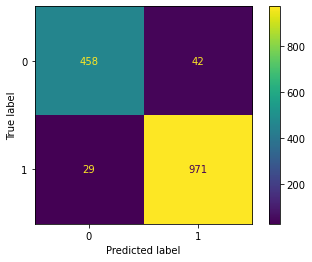

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_Gen)
disp.plot()

plt.show()

True Label => is genuine
predicted Label => Résultat Cluster

## K-Means

In [56]:
matrix #Performance du k-mean

array([[481,  19],
       [  2, 998]], dtype=int64)

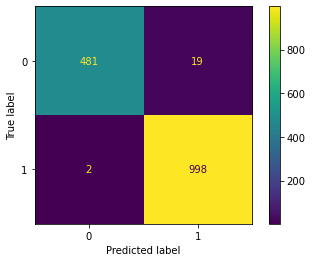

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

plt.show()

# Utilisation du modèle

In [58]:
#Prédire les billets de production avec la regression logistique
df_test = pd.read_csv('billets_test.csv', sep=",", decimal=".", header=0)

df_test = df_test.drop(["id"], axis=1)
df_test[["Proba_1","Proba_2"]] = logreg.predict_proba(df_test)
df_test["Score_Reg_Log"] = logreg.predict(df_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,Proba_1,Proba_2,Score_Reg_Log
0,172.09,103.95,103.73,4.39,3.09,113.19,0.070207,0.929793,1
1,171.52,104.17,104.03,5.27,3.16,111.82,0.878879,0.121121,0
2,171.78,103.80,103.75,3.81,3.24,113.39,0.022620,0.977380,1
3,172.02,104.08,103.99,5.57,3.30,111.10,0.981888,0.018112,0
4,171.79,104.34,104.37,5.00,3.07,111.87,0.834892,0.165108,0
